# Übung 6: MNIST mit CNNs

In [1]:
import tensorflow as tf

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

## Aufgabe 1: MNIST-CNN und erweiterte Evaluation

In [28]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D, Dropout

### Aufgabe 1a

In [3]:
lenet = tf.keras.Sequential([
    Input(shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=120, activation="relu"),
    Dense(units=84, activation="relu"),
    Dense(units=10, activation="softmax")
])

In [4]:
lenet.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Datensatz laden

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

MNIST-Bilder sind (28,28), unser Input verlangt aber (32,32,1) <br>
Zum Hochskalieren eignet sich z.B. skimage.transform, da wir mit Numpy-Arrays arbeiten. Eine Alternative zum resizing wäre auch padding. <br>
Liest man die Bilder laufend ein, kann man auch über den Keras ImageDataGenerator über z.B. flow_from_directory eine target_size angeben

In [6]:
from skimage.transform import resize

In [7]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [8]:
x_train = resize(x_train, (60000, 32, 32, 1))
x_train.shape

(60000, 32, 32, 1)

In [9]:
x_test = resize(x_test, (10000, 32, 32, 1))
x_test.shape

(10000, 32, 32, 1)

Hinweis: Runterskalieren ist nicht mehr nötig, da resize von skimage bereits Pixel im Bereich [0,1] ausgibt.

In [10]:
# Training parameters
epochs = 5
batch_size = 32
steps_per_epoch = len(x_train) // batch_size

In [11]:
lenet.fit(x_train, y_train, 
         batch_size=batch_size,
         epochs=epochs,
         shuffle=True)

Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1696 - accuracy: 0.9484
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0585 - accuracy: 0.9818
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0433 - accuracy: 0.9870
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0338 - accuracy: 0.9892
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0269 - accuracy: 0.9914


In [12]:
lenet.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0364 - accuracy: 0.9884


[0.036367520689964294, 0.9883999824523926]

### Aufgabe 1b

<b>Berechnung der trainierbaren Parameter:</b><br>
Für jedes Layer:
<ul>
    <li>Conv1: 6x(5x5)x1 + 6 = 156 </li>
    <li>MaxPool1: 0</li>
    <li>Conv2: 16x(5x5)x6 + 16 = 2416 </li>
    <li>MaxPool2: 0</li>
    <li>Flatten: 16x(5x5) = 400 Knoten (aber 0 Parameter)</li>
    <li>Dense1: 120x400 + 120 = 48120</li>
    <li>Dense2: 84x120 + 84 = 10164</li>
    <li>Dense3: 10x84 + 10 = 850</li>
</ul>
Damit insgesamt: 156 + 2416 + 48120 + 10164 + 850 = <b>61706</b>

In [13]:
lenet.count_params()

61706

In [14]:
lenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

### Aufgabe 1c

In [13]:
import numpy as np

In [14]:
probability = lenet.predict(x_test)
prediction = np.argmax(probability, axis=-1)
prediction

array([7, 2, 1, ..., 4, 5, 6])

Zunächst brauchen wir die jeweils maximale Wahrscheinlichkeit pro Beispiel

In [15]:
probability_single = np.max(probability, axis=-1)
probability_single

array([0.99999654, 0.9999994 , 0.99953604, ..., 0.9999999 , 0.999998  ,
       0.9999982 ], dtype=float32)

Die 25 schlechtesten Wahrscheinlichkeiten sind dann:

In [16]:
np.sort(probability_single)[0:25]

array([0.25027105, 0.32237345, 0.3307323 , 0.343515  , 0.34764057,
       0.35251933, 0.35737082, 0.35922673, 0.3943154 , 0.40004846,
       0.40567377, 0.42559004, 0.42899248, 0.42919573, 0.43484932,
       0.435264  , 0.43591508, 0.4521426 , 0.46640006, 0.47240144,
       0.47401866, 0.47562665, 0.47949913, 0.49373424, 0.4937948 ],
      dtype=float32)

Diese müssen wir sortieren und mit Ground Truth und Predictions abgleichen, um die 25 schlechtesten Beispiele zu finden. Dafür eignet sich numpy.argsort

In [17]:
bad_predictions_idx = np.argsort(probability_single)[0:25]
bad_images = x_test[bad_predictions_idx]
bad_predictions = prediction[bad_predictions_idx]
bad_probabilities = probability_single[bad_predictions_idx]
ground_truths = y_test[bad_predictions_idx]

Diese müssen wir jetzt nur noch plotten.

In [18]:
import matplotlib.pyplot as plt

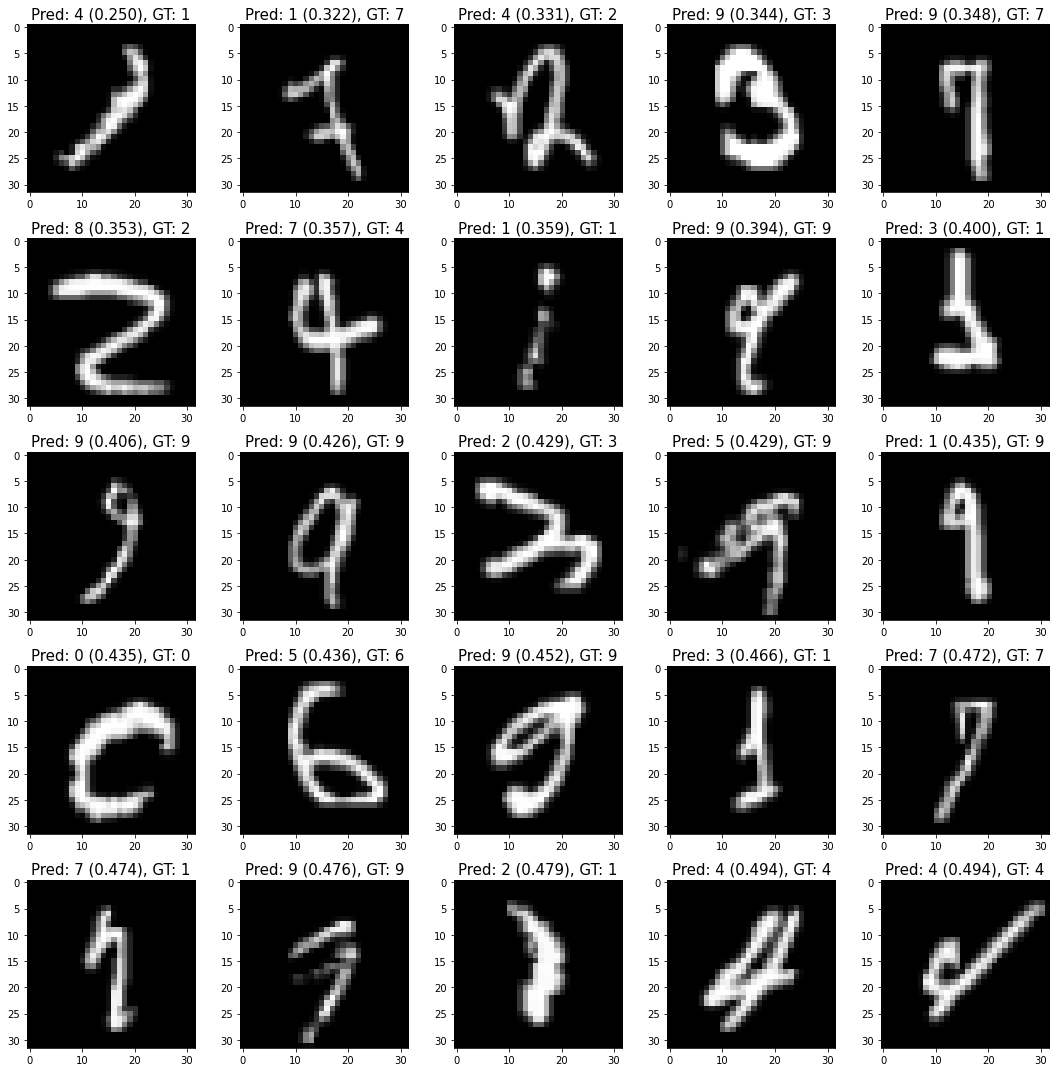

In [19]:
fig = plt.figure(figsize=(15,15))
for idx, img in enumerate(bad_images):
    title = 'Pred: '+ str(bad_predictions[idx]) + ' ('+ '{:.3f}'.format(bad_probabilities[idx]) + ')' +', GT: ' + str(ground_truths[idx])
    ax = fig.add_subplot(5, 5, idx+1)
    ax.imshow(img[:,:,0], cmap='gray')
    ax.set_title(title, fontsize=15)
fig.tight_layout()

### Aufgabe 1d

Über unser Probability Array können wir mit Hilfe eines Loops einfach die Top-2 Accuracy bestimmen. Alternativ könnte man in Keras eine Custom Metrik einbauen und es so bestimmen.

In [22]:
correct_count = 0
for i, prob in enumerate(probability):
    top2 = prob.argsort()[-2:]
    if y_test[i] in top2:
        correct_count += 1
top2_accuracy = correct_count/len(y_test)
top2_accuracy

0.9979

## Aufgabe 2

### Aufgabe 2a

Neues Modell mit neuen Gewichten erstellen

In [23]:
lenet2 = tf.keras.Sequential([
    Input(shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=120, activation="relu"),
    Dense(units=84, activation="relu"),
    Dense(units=10, activation="softmax")
])

lenet2.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Erstellen des kleineren Trainigssets. Wir wollen etwa 50 Beispiele pro Klasse. Dafür können wir x_train und y_train zusammen shufflen und die ersten 500 Einträge nehmen. Da die Klassen vorher etwa gleich verteilt waren, sollte das auch hier eine Balance geben.

In [24]:
random_idx = np.random.permutation(60000)[:500]
x_train_small = x_train[random_idx]
y_train_small = y_train[random_idx]

Hier nochmal die Anzahl der Beispiele pro Klasse aufgelistet:

In [25]:
np.unique(y_train_small, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([58, 48, 49, 43, 52, 44, 51, 56, 47, 52], dtype=int64))

In [26]:
# Training parameters
epochs = 10 
batch_size = 16 # kleinere Batch Size, um mehr Iterationen pro Epoche zu erhalten
steps_per_epoch = len(x_train_small) // batch_size

In [27]:
lenet2.fit(x_train_small, y_train_small, 
         batch_size=batch_size,
         epochs=epochs,
         shuffle=True)

Epoch 1/10
32/32 [==============================] - 0s 3ms/step - loss: 2.0305 - accuracy: 0.3320
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.9394 - accuracy: 0.7180
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5212 - accuracy: 0.8440
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.8620
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2973 - accuracy: 0.9200
Epoch 6/10
32/32 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 1.00 - 0s 2ms/step - loss: 0.2031 - accuracy: 0.9360
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1959 - accuracy: 0.9420
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1294 - accuracy: 0.9560
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0865 - accuracy: 0.9820
Epoch 10/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0

In [28]:
lenet2.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3296 - accuracy: 0.9081


[0.32964959740638733, 0.9081000089645386]

### Aufgabe 2b

In [29]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [30]:
# lambda regularizer
l = 0.01

In [31]:
lenet3 = tf.keras.Sequential([
    Input(shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=120, activation="relu", kernel_regularizer=l2(l), bias_regularizer=l2(l)), # neue Terme
    Dropout(rate=0.5), # Neue Schicht 
    Dense(units=84, activation="relu", kernel_regularizer=l2(l), bias_regularizer=l2(l)), # neue Terme
    Dropout(rate=0.5), # Neue Schicht
    Dense(units=10, activation="softmax", kernel_regularizer=l2(l), bias_regularizer=l2(l)) # neue Terme
])

lenet3.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [32]:
# Training parameters
epochs = 20  # mehr Epochen wegen Dropout und Regularisierungsterm
batch_size = 16 
steps_per_epoch = len(x_train_small) // batch_size

In [33]:
lenet3.fit(x_train_small, y_train_small, 
         batch_size=batch_size,
         epochs=epochs,
         shuffle=True)

Epoch 1/20
32/32 [==============================] - 0s 2ms/step - loss: 4.7294 - accuracy: 0.1320
Epoch 2/20
32/32 [==============================] - 0s 2ms/step - loss: 3.6442 - accuracy: 0.2960
Epoch 3/20
32/32 [==============================] - 0s 2ms/step - loss: 2.8009 - accuracy: 0.4540
Epoch 4/20
32/32 [==============================] - 0s 2ms/step - loss: 2.2988 - accuracy: 0.5500
Epoch 5/20
32/32 [==============================] - 0s 2ms/step - loss: 2.0102 - accuracy: 0.6520
Epoch 6/20
32/32 [==============================] - 0s 2ms/step - loss: 1.8328 - accuracy: 0.6960
Epoch 7/20
32/32 [==============================] - 0s 2ms/step - loss: 1.6682 - accuracy: 0.7300
Epoch 8/20
32/32 [==============================] - 0s 2ms/step - loss: 1.5119 - accuracy: 0.7720
Epoch 9/20
32/32 [==============================] - 0s 2ms/step - loss: 1.4275 - accuracy: 0.7720
Epoch 10/20
32/32 [==============================] - 0s 2ms/step - loss: 1.3344 - accuracy: 0.8220
Epoch 11/20
32/32 [

In [34]:
lenet3.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.7668 - accuracy: 0.9331


[0.7667927145957947, 0.9330999851226807]

## Aufgabe 2c

Zur Datenaugmentierung nehmen wir den ImageDataGenerator von Keras, dann können wir über die flow-Funktion einen Generator zum Trainieren erstellen. <br> <br>
Als Augmentierungen eignen sich geringe Rotationen, leichter Crop (zoom), kleine Translationen (width_shift und height_shift) und evtl. brightness und shear. <br>
Die exakten Werte sind Hyperparameter, die sich Optimieren lassen, d.h. die hier gewählten Werte müssen nicht die besten sein. <br>
Horizontal und Vertical flip sowie größere Werte bei Rotation etc. sind ungeeignet, da sie das Label ändern würden. Rescale ist prinzipiell gut, da es die Bilder auf verschiedene Skalen/Auflösungen transformiert. Da unser Netz aber eine feste Auflösung verlangt, können wir das nicht verwenden.<br><br>
Zusätzlich fitten wir unseren Data Generator auf unser Trainingsset, um Pixelwerte in Werten der Standardabweichung zu erhalten.

In [35]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                               featurewise_std_normalization=True,
                                                               rotation_range=10,
                                                               width_shift_range=0.05,
                                                               height_shift_range=0.05,
                                                               zoom_range=0.10)
train_datagen.fit(x_train_small)

# Da wir auf den Datensatz fitten, brauchen wir noch einen gefitteten test-generator zur Evaluation
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                              featurewise_std_normalization=True)
test_datagen.fit(x_train_small)

In [36]:
# Training parameters
epochs = 30  # mehr Epochen wegen Dropout, Regularisierungsterm und Datenaugmentierung
batch_size = 16
steps_per_epoch = len(x_train_small) // batch_size

In [37]:
train_generator = train_datagen.flow(x_train_small, 
                                     y=y_train_small,
                                     batch_size=batch_size,
                                     shuffle=True)

In [38]:
# Gleiches Netz wie vorher
lenet4 = tf.keras.Sequential([
    Input(shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=120, activation="relu", kernel_regularizer=l2(l), bias_regularizer=l2(l)), # neue Terme
    Dropout(rate=0.5), # Neue Schicht 
    Dense(units=84, activation="relu", kernel_regularizer=l2(l), bias_regularizer=l2(l)), # neue Terme
    Dropout(rate=0.5), # Neue Schicht
    Dense(units=10, activation="softmax", kernel_regularizer=l2(l), bias_regularizer=l2(l)) # neue Terme
])

lenet4.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [39]:
lenet4.fit(train_generator, 
           epochs=epochs,
           steps_per_epoch=steps_per_epoch)

Epoch 1/30
31/31 [==============================] - 0s 4ms/step - loss: 4.8442 - accuracy: 0.1405
Epoch 2/30
31/31 [==============================] - 0s 3ms/step - loss: 3.9457 - accuracy: 0.2769
Epoch 3/30
31/31 [==============================] - 0s 3ms/step - loss: 3.2977 - accuracy: 0.3120
Epoch 4/30
31/31 [==============================] - 0s 3ms/step - loss: 2.8070 - accuracy: 0.4698
Epoch 5/30
31/31 [==============================] - 0s 4ms/step - loss: 2.3523 - accuracy: 0.5289
Epoch 6/30
31/31 [==============================] - 0s 3ms/step - loss: 2.1488 - accuracy: 0.5971
Epoch 7/30
31/31 [==============================] - 0s 3ms/step - loss: 1.9461 - accuracy: 0.6550
Epoch 8/30
31/31 [==============================] - 0s 3ms/step - loss: 1.7796 - accuracy: 0.6736
Epoch 9/30
31/31 [==============================] - 0s 3ms/step - loss: 1.6509 - accuracy: 0.7231
Epoch 10/30
31/31 [==============================] - 0s 3ms/step - loss: 1.5972 - accuracy: 0.7252
Epoch 11/30
31/31 [

In [40]:
test_generator = test_datagen.flow(x_test,
                                   y=y_test,
                                   batch_size=50,
                                   shuffle=False)

In [41]:
lenet4.evaluate(test_generator)

200/200 [==============================] - 0s 1ms/step - loss: 0.6540 - accuracy: 0.9429


[0.6539523601531982, 0.9429000020027161]

### Aufgabe 2d

Jetzt wieder ohne Dropout, Regularisierungsterm und Datenaugmentierung. Stattdessen benutzen wir Transfer-Learning jeweils für Fashion-MNIST und CIFAR-100. Fangen wir zunächst mit Fashion-MNIST an. Das Modell muss dafür nicht weiter angepasst werden, da Fashion-MNIST ebenfalls 10 Klassen besitzt.

In [42]:
lenet_fashion = tf.keras.Sequential([
    Input(shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=120, activation="relu"),
    Dense(units=84, activation="relu"),
    Dense(units=10, activation="softmax")
])

lenet_fashion.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Datensatz einladen und hochskalieren

In [43]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train_f, y_train_f), (x_test_f, y_test_f) = fashion_mnist.load_data()

In [44]:
x_train_f.shape, y_train_f.shape, x_test_f.shape, y_test_f.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [45]:
x_train_f = resize(x_train_f, (60000, 32, 32, 1))
x_test_f = resize(x_test_f, (10000, 32, 32, 1))

In [46]:
# Training parameters
epochs = 10
batch_size = 32

In [47]:
lenet_fashion.fit(x_train_f, y_train_f, 
         batch_size=batch_size,
         epochs=epochs,
         shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5322 - accuracy: 0.8068
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3598 - accuracy: 0.8698
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3162 - accuracy: 0.8840
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2877 - accuracy: 0.8928
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2658 - accuracy: 0.9008
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2455 - accuracy: 0.9088
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2322 - accuracy: 0.9140
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2185 - accuracy: 0.9176
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2046 - accuracy: 0.9216
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.195

In [48]:
lenet_fashion.evaluate(x_test_f, y_test_f)

313/313 [==============================] - 0s 1ms/step - loss: 0.2855 - accuracy: 0.8989


[0.2855498790740967, 0.8988999724388123]

Auf den MNIST-Daten ist das Modell noch sehr schlecht (aber besser als random), da die Schichten zur Klassifikation noch neu trainiert werden müssen.

In [49]:
lenet_fashion.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 11.8998 - accuracy: 0.0992


[11.899849891662598, 0.09920000284910202]

Nun trainieren wir es um auf unseren kleinen MNIST-Trainingsdatensatz. Dank gleicher Dimensionen und Klassenzahl müssen wir hier nichts mehr ändern.

In [50]:
lenet_fashion.fit(x_train_small, y_train_small, 
         batch_size=batch_size,
         epochs=5,
         shuffle=True)

Epoch 1/5
16/16 [==============================] - 0s 4ms/step - loss: 3.9868 - accuracy: 0.3100
Epoch 2/5
16/16 [==============================] - 0s 2ms/step - loss: 1.0810 - accuracy: 0.6620
Epoch 3/5
16/16 [==============================] - 0s 2ms/step - loss: 0.5794 - accuracy: 0.8180
Epoch 4/5
16/16 [==============================] - 0s 2ms/step - loss: 0.3366 - accuracy: 0.9020
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 0.2311 - accuracy: 0.9440


In [51]:
lenet_fashion.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.5199 - accuracy: 0.8520


[0.5199322700500488, 0.8519999980926514]

Das gleiche machen wir jetzt für CIFAR-100. Die Dimensionen der Bilder liegen bei (32, 32, 3), sodass wir unseren Input auf 3 Channels erweitern müssen. Dafür müssen wir die Bilder nicht hochskalieren. Die Pixelwerte skalieren wir noch manuell auf [0,1].

In [20]:
cifar100 = tf.keras.datasets.cifar100
(x_train_c, y_train_c), (x_test_c, y_test_c) = cifar100.load_data()
x_train_c, x_test_c = x_train_c / 255., x_test_c / 255.

169009152/169001437 [==============================] - 27s 0us/step


In [21]:
x_train_c.shape, y_train_c.shape, x_test_c.shape, y_test_c.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Das letzte Dense Layer benötigt nun logischerweise 100 statt 10 Klassen:

In [47]:
lenet_cifar = tf.keras.Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(filters=6, kernel_size=3, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=32, kernel_size=3, activation="relu"),
    # MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=64, kernel_size=3, activation="relu"),
    # MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dropout(0.3),
    Dense(units=64, activation="relu"),
    Dropout(0.5),
    Dense(units=100, activation="softmax")
])

lenet_cifar.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [48]:
lenet_cifar.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 30, 30, 6)         168       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 13, 16)        880       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten_6 (Flatten)          (None, 256)             

In [49]:
# Training parameters
epochs = 20
batch_size = 32

In [50]:
lenet_cifar.fit(x_train_c, y_train_c,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2,
                shuffle=True)

ResourceExhaustedError: OOM when allocating tensor with shape[40000,32,32,3] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:GatherV2]

In [25]:
lenet_cifar.evaluate(x_test_c, y_test_c)

313/313 [==============================] - 0s 1ms/step - loss: 3.0271 - accuracy: 0.2942


[3.0270752906799316, 0.29420000314712524]

Das Training für CIFAR-100 dauert wesentlich länger, aber wir möchten unsere Gewichte ja nur "anschubsen", daher reicht schon eine kleinere Genauigkeit. Zur Anwendung auf unseren kleinen MNIST-Datensatz müssen wir zwei Dinge tun: <br>
1. Den letzten Layer des Modells entfernen und das passende hinzufügen.
2. Unser Bilder auf 3 Channels duplizieren, d.h. jeder der drei Channel hat die gleichen Einträge.

In [58]:
lenet_mnist = tf.keras.Sequential()
lenet_mnist.add(Input(shape=(32, 32, 3)))
for layer in lenet_cifar.layers[:-1]:
    lenet_mnist.add(layer)
lenet_mnist.add(Dense(units=10, activation="softmax"))

lenet_mnist.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [59]:
lenet_mnist.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_16 (Dense)             (None, 84)               

In [60]:
x_train_small.shape, x_test.shape

((500, 32, 32, 1), (10000, 32, 32, 1))

Zur Erweiterung auf 3 Channels eignet sich numpy.repeat:

In [61]:
x_train_small_3 = np.repeat(x_train_small, 3, axis=-1)
x_test_3 = np.repeat(x_test, 3, axis=-1)
x_train_small_3.shape, x_test_3.shape

((500, 32, 32, 3), (10000, 32, 32, 3))

In [62]:
# Training parameters
epochs = 5
batch_size = 32

In [63]:
lenet_mnist.fit(x_train_small_3, y_train_small,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True)

Epoch 1/5
16/16 [==============================] - 0s 3ms/step - loss: 3.4987 - accuracy: 0.1480
Epoch 2/5
16/16 [==============================] - 0s 2ms/step - loss: 1.6391 - accuracy: 0.4700
Epoch 3/5
16/16 [==============================] - 0s 2ms/step - loss: 0.9766 - accuracy: 0.7420
Epoch 4/5
16/16 [==============================] - 0s 2ms/step - loss: 0.5990 - accuracy: 0.8300
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 0.3679 - accuracy: 0.8980


In [64]:
lenet_mnist.evaluate(x_test_3, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.4941 - accuracy: 0.8435


[0.49406519532203674, 0.843500018119812]